## What is the most optimal skill to learn for Data Engineer?

### Methodology

1. Group skills to determine median salary and likelihood of being in posting
2. Visualize median salary vs. percent skill demand
3. Determine if certain technologies are more prevalent

In [1]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import ast
import seaborn as sns

dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda skill: ast.literal_eval(skill) if pd.notna(skill) else skill)

In [2]:
df_de_us = df[(df['job_country']=='United States') & (df['job_title_short']=='Data Engineer')].copy()
df_de_us = df_de_us.dropna(subset='salary_year_avg')
df_de_exploded = df_de_us.explode('job_skills')
df_de_skills = df_de_exploded.groupby('job_skills')['salary_year_avg'].agg(['count','median']).sort_values(by='count',ascending=False)
df_de_skills = df_de_skills.rename(columns={'count':'skill_count', 'median':'median_salary'})
de_job_count = len(df_de_us)
df_de_skills['skill_percent'] = 100 *df_de_skills['skill_count'] / de_job_count
skill_percent = 15
df_de_skills = df_de_skills[df_de_skills['skill_percent'] > skill_percent]

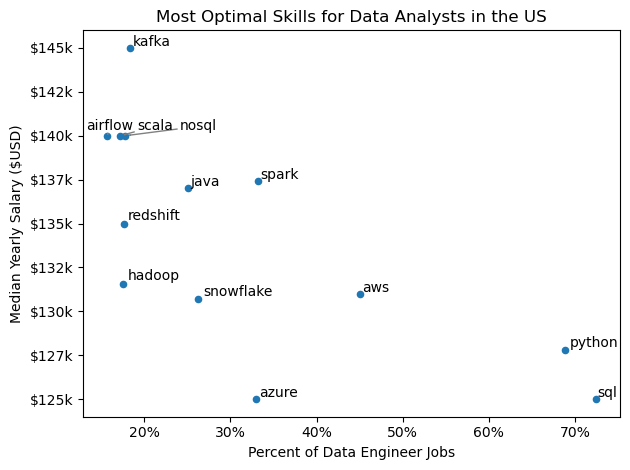

In [3]:
from adjustText import adjust_text
from matplotlib.ticker import PercentFormatter
df_de_skills.plot(kind='scatter',x='skill_percent',y='median_salary')
texts = []
for i, txt in enumerate(df_de_skills.index):
    texts.append(plt.text(df_de_skills['skill_percent'].iloc[i], df_de_skills['median_salary'].iloc[i],txt))
adjust_text(texts, arrowprops=dict(arrowstyle="->",color='gray',lw=1))
ax=plt.gca() #fig, ax = plt.subplots() is an alternative to this code
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}k'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))
plt.xlabel('Percent of Data Engineer Jobs')
plt.ylabel('Median Yearly Salary ($USD)')
plt.title('Most Optimal Skills for Data Analysts in the US')
plt.tight_layout()

In [4]:
df_technology = df['job_type_skills'].copy()

# remove duplicates
df_technology = df_technology.drop_duplicates()

# remove NaN values
df_technology = df_technology.dropna()

# combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row)  # convert string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict:  # if key already exists in technology_dict, add value to existing value
            technology_dict[key] += value
        else:                       # if key does not exist in technology_dict, add key and value
            technology_dict[key] = value

# remove duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

In [5]:
df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology','skills'])
df_tech_exploded = df_technology.explode('skills')
df_de_skills = df_de_skills.merge(df_tech_exploded, left_on='job_skills', right_on='skills')

In [10]:
df_de_skills = df_de_skills.set_index('skills')

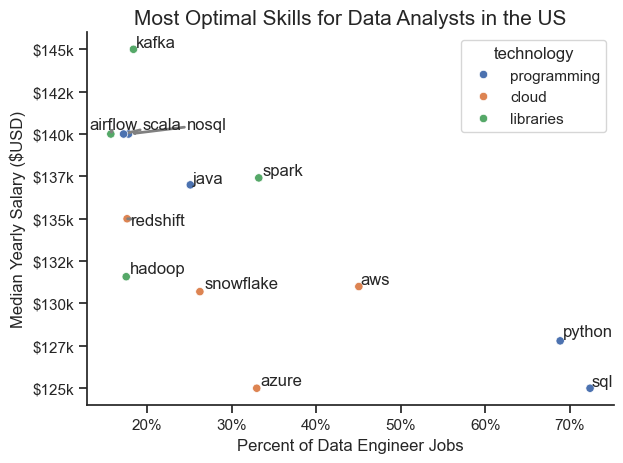

In [13]:
# df_de_skills.plot(kind='scatter',x='skill_percent',y='median_salary')
sns.scatterplot(
    data=df_de_skills,
    x='skill_percent',
    y='median_salary',
    hue='technology'
)
sns.despine()
sns.set_theme(style='ticks')
texts = []
for i, txt in enumerate(df_de_skills.index):
    texts.append(plt.text(df_de_skills['skill_percent'].iloc[i], df_de_skills['median_salary'].iloc[i],txt))
adjust_text(texts, arrowprops=dict(arrowstyle="->",color='gray',lw=2))
ax=plt.gca() #fig, ax = plt.subplots() is an alternative to this code
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}k'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))
plt.xlabel('Percent of Data Engineer Jobs')
plt.ylabel('Median Yearly Salary ($USD)')
plt.title('Most Optimal Skills for Data Analysts in the US', fontsize=15)
plt.tight_layout()